In [1]:
from create_percent_diff_summary import invert_dotson_fcn, invert_pig_fcn, invert_thwaites_fcn, eval_models
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colorbar as colorbar
import os
import sys
import copy
import pickle
import pandas as pd
import firedrake

2024-11-23 05:32:05.290530: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-23 05:32:09.953733: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-23 05:32:13.276665: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732339936.551955    1090 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732339937.714940    1090 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-23 05:32:25.420347: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [ ]:
# Get the evaluated objects and results for Dotson, PIG, and Thwaites
inv_dotson = invert_dotson_fcn()

Reading local outline
Creating mesh
Reading mesh
Reading bedmachine data
Initializing function spaces
Initializing 3d function spaces
Initializing fields
Defining friction law
Setting ramp power to :  1
Initializing heat transport
Reading velocity from measures database
C0 is constant: 0.01
Defining friction law
Defining friction law
using englacial temperature for rate factor
Geophysics data imported
Using loss function without sigma

Truncated CG Trust-Region Solver
  iter  value          gnorm          snorm          delta          #fval     #grad     tr_flag   iterCG    flagCG    
  0     2.208362e+08   1.165900e+04                  1.973342e+04   
  1     7.671563e+07   4.153294e+03   1.973342e+04   4.933356e+04   3         2         0         2         3         
  2     1.371842e+07   6.355098e+02   4.933356e+04   4.933356e+04   4         3         0         2         2         
  3     3.119954e+06   1.450287e+02   4.933356e+04   4.933356e+04   5         4         0         2  

In [ ]:
inv_pig = invert_pig_fcn()

In [ ]:
inv_thwaites = invert_thwaites_fcn()

In [ ]:
inv_loss_thwaites = firedrake.assemble(inv_thwaites.loss_functional_nosigma(inv_thwaites.inverse_u))
inv_loss_dotson = firedrake.assemble(inv_dotson.loss_functional_nosigma(inv_dotson.inverse_u))
inv_loss_pig = firedrake.assemble(inv_pig.loss_functional_nosigma(inv_pig.inverse_u))

In [ ]:

print("Cost function Thwaites:", firedrake.assemble(inv_thwaites.loss_functional_nosigma(inv_thwaites.inverse_u)))
print("Cost function PIG:", firedrake.assemble(inv_pig.loss_functional_nosigma(inv_pig.inverse_u)))
print("Cost function Dotson:", firedrake.assemble(inv_dotson.loss_functional_nosigma(inv_dotson.inverse_u)))

Cost function Thwaites: 733.725504184043
Cost function PIG: 9942.626422748715
Cost function Dotson: 1248.372044290589


In [ ]:
select_dataset = 5

In [ ]:
%%capture
temp_objects_dotson, summary_list_dotson, columns_list_dotson, u_optimized_list_dotson, loss_function_list_dotson = eval_models(select_dataset, inv_dotson)
temp_objects_pig, summary_list_pig, columns_list_pig, u_optimized_list_pig, loss_function_list_pig = eval_models(select_dataset, inv_pig)
temp_objects_thwaites, summary_list_thwaites, columns_list_thwaites, u_optimized_list_thwaites, loss_function_list_thwaites = eval_models(select_dataset, inv_thwaites)

In [ ]:
# %%capture
# temp_objects_pig, summary_list_pig, columns_list_pig, u_optimized_list_pig, loss_function_list_pig = eval_models(select_dataset, inv_pig)

In [ ]:
# %%capture
# temp_objects_thwaites, summary_list_thwaites, columns_list_thwaites, u_optimized_list_thwaites, loss_function_list_thwaites = eval_models(select_dataset, inv_thwaites)

In [ ]:
from firedrake import dx, max_value
def return_percent_diff(inv_obj):
    u_inv_norm = inv_obj.get_magnitude(inv_obj.inverse_u)
    u_default_norm = inv_obj.get_magnitude(inv_obj.default_u)
    u_ML_norm = inv_obj.get_magnitude(inv_obj.ML_u)
    ml_difference = firedrake.sqrt((u_inv_norm - u_ML_norm)**2)
    default_difference = firedrake.sqrt((u_inv_norm - u_default_norm)**2) 
    percent_difference = 100 * (default_difference - ml_difference) / default_difference
    percent_difference_capped = max_value(percent_difference, 0)
    percent_100 =  100 * (default_difference) / default_difference
    return firedrake.assemble(percent_difference_capped* dx)/firedrake.assemble(percent_100*dx) 

tsfc:WARNING Estimated quadrature degree 28 more than tenfold greater than any argument/coefficient degree (max 2)


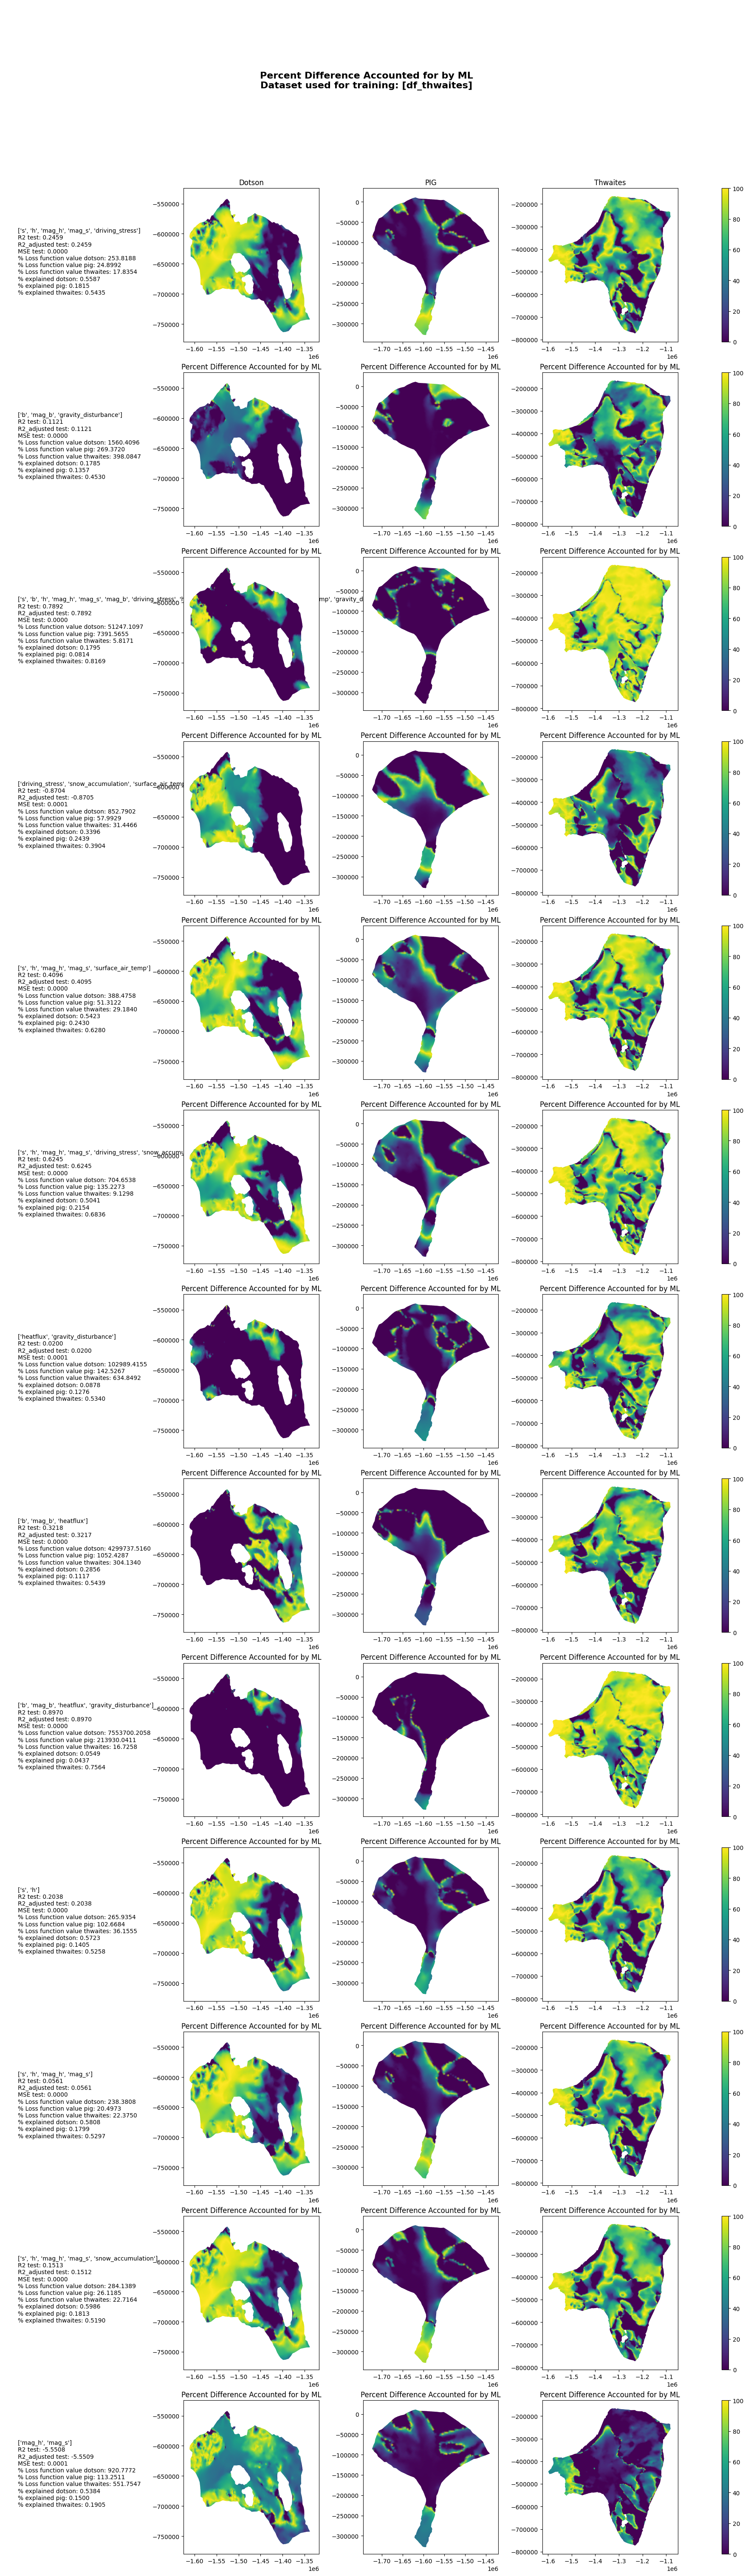

In [ ]:
# Determine the dataset used based on select_dataset
if select_dataset == 0:
    dataset_used = "[df_dotson, df_dotson, df_thwaites]"
elif select_dataset == 1:
    dataset_used = "[df_pig, df_pig, df_thwaites]"
elif select_dataset == 2:
    dataset_used = "[df_dotson, df_pig]"
elif select_dataset == 3:
    dataset_used = "[df_dotson]"
elif select_dataset == 4:
    dataset_used = "[df_pig]"
elif select_dataset == 5:
    dataset_used = "[df_thwaites]"

# Since the lists have an equal number of objects, determine the number of rows
n_rows = len(temp_objects_dotson)

# Increase figure size to make the rows larger
fig = plt.figure(figsize=(22, 6 * n_rows))

# Create a gridspec layout with an extra row for the title
# Reduce hspace to decrease vertical gaps between rows
gs = gridspec.GridSpec(n_rows + 1, 5, width_ratios=[4, 4, 4, 4, 0.2], wspace=0.4, hspace=0.2)

# Add a new axes for the title with the dynamic dataset info
ax_title = fig.add_subplot(gs[0, :])
title_text = f"Percent Difference Accounted for by ML\nDataset used for training: {dataset_used}"
ax_title.text(0.5, 0.5, title_text, fontsize=16, weight='bold', ha='center', va='center')
ax_title.axis('off')  # Turn off the axis for the title

# Loop over the objects and plot in the corresponding grid positions
for row in range(n_rows):
    # Summary column (column 0)
    ax_summary = fig.add_subplot(gs[row + 1, 0])
    summary_text = (
        f"{columns_list_dotson[row]}\n"
        f"R2 test: {summary_list_dotson[row]['r2_mean']:.4f}\n"
        f"R2_adjusted test: {summary_list_dotson[row]['r2_adjusted_mean']:.4f}\n"
        f"MSE test: {summary_list_dotson[row]['mse_mean']:.4f}\n"
        f"% Loss function value dotson: {(loss_function_list_dotson[row]-inv_loss_dotson)/inv_loss_dotson:.4f}\n"
        f"% Loss function value pig: {(loss_function_list_pig[row]-inv_loss_pig)/inv_loss_pig:.4f}\n"
        f"% Loss function value thwaites: {(loss_function_list_thwaites[row]-inv_loss_thwaites)/inv_loss_thwaites:.4f}\n"
        f"% explained dotson: {return_percent_diff(temp_objects_dotson[row]):.4f}\n"
        f"% explained pig: {return_percent_diff(temp_objects_pig[row]):.4f}\n"
        f"% explained thwaites: {return_percent_diff(temp_objects_thwaites[row]):.4f}\n"
        
    )
    ax_summary.text(0.1, 0.5, summary_text, fontsize=10, va="center", ha="left")
    ax_summary.axis('off')  # Turn off the axis for the text column
    
    # Dotson column (column 1)
    ax_dotson = fig.add_subplot(gs[row + 1, 1])
    _, ax_dotson = temp_objects_dotson[row].plot_percent_accounted(vmin=0, vmax = 100, axes=ax_dotson)
    if row == 0:
        ax_dotson.set_title("Dotson")
    
    # PIG column (column 2)
    ax_pig = fig.add_subplot(gs[row + 1, 2])
    _, ax_pig = temp_objects_pig[row].plot_percent_accounted(vmin=0, vmax = 100,  axes=ax_pig)
    if row == 0:
        ax_pig.set_title("PIG")
    
    # Thwaites column (column 3)
    ax_thwaites = fig.add_subplot(gs[row + 1, 3])
    _, ax_thwaites = temp_objects_thwaites[row].plot_percent_accounted(vmin=0, vmax = 100, axes=ax_thwaites)
    if row == 0:
        ax_thwaites.set_title("Thwaites")

    # Create a color bar at the end of the row (column 4)
    cax = fig.add_subplot(gs[row + 1, 4])
    fig.colorbar(ax_dotson.collections[0], cax=cax)

# Show the final figure
plt.show()


In [ ]:
import seaborn as sns
# Feature symbol mapping
FEATURE_SYMBOLS = {
    "s": "s",
    "b": "b",
    "h": "h",
    "mag_s": "∥∇s∥",
    "mag_b": "∥∇b∥",
    "mag_h": "∥∇h∥",
    "driving_stress": "τd",
    "gravity_disturbance": "gd",
    "heatflux": "Qb",
    "surface_air_temp": "Ts",
    "snow_accumulation": "As",
}

# Dataset labels
DATASET_NAMES = [
    "[dotson, thwaites]",
    "[pig, thwaites]",
    "[dotson, pig]",
    "[dotson]",
    "[pig]",
    "[thwaites]",
]

# Training dataset mapping
CATCHMENT_NAMES = ["Dotson", "Pig", "Thwaites"]
TRAINING_MAPPING = {
    0: ["Dotson", "Dotson", "Thwaites"],
    1: ["Pig", "Pig", "Thwaites"],
    2: ["Dotson", "Pig"],
    3: ["Dotson"],
    4: ["Pig"],
    5: ["Thwaites"]
}

# Initialize a storage dictionary
eval_results = {}

# Precompute and store results for all datasets
for select_dataset in range(6):
    print(f"Processing dataset {select_dataset}...")
    
    eval_results[select_dataset] = {
        "dotson": eval_models(select_dataset, inv_dotson),
        "pig": eval_models(select_dataset, inv_pig),
        "thwaites": eval_models(select_dataset, inv_thwaites),
    }

Processing dataset 0...
dataset selected: [df_dotson,df_dotson,df_thwaites]
Processing folder: -2074223237608632438
model_5_dotson2_thwaites1_r01_geo_mixed
['s', 'h', 'mag_h', 'mag_s', 'surface_air_temp']
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Processing folder: 3018420796423631326
model_7_dotson2_thwaites1_r01_geo_mixed
['s', 'h', 'mag_h', 'mag_s', 'driving_stress', 'snow_accumulation', 'surface_air_temp']
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
287/287 ━━━━━

In [ ]:

# Process and plot results for all datasets
all_percent_explained_avg = []

for select_dataset in range(6):
    print(f"Analyzing dataset {select_dataset}...")
    
    # Retrieve precomputed results
    temp_objects_dotson, summary_list_dotson, columns_list_dotson, u_optimized_list_dotson, loss_function_list_dotson = eval_results[select_dataset]["dotson"]
    temp_objects_pig, summary_list_pig, columns_list_pig, u_optimized_list_pig, loss_function_list_pig = eval_results[select_dataset]["pig"]
    temp_objects_thwaites, summary_list_thwaites, columns_list_thwaites, u_optimized_list_thwaites, loss_function_list_thwaites = eval_results[select_dataset]["thwaites"]

    # Identify training and excluded catchments
    training_catchments = TRAINING_MAPPING[select_dataset]
    excluded_catchments = [c for c in CATCHMENT_NAMES if c not in training_catchments]
    
    # Retrieve the percentage explained for each excluded catchment
    percent_explained = []
    for catchment in excluded_catchments:
        if catchment == "Dotson":
            percent_explained.append([return_percent_diff(obj) for obj in temp_objects_dotson])
        elif catchment == "Pig":
            percent_explained.append([return_percent_diff(obj) for obj in temp_objects_pig])
        elif catchment == "Thwaites":
            percent_explained.append([return_percent_diff(obj) for obj in temp_objects_thwaites])
    
    # Compute the average percentage explained for each feature subset
    percent_explained_avg = np.mean(percent_explained, axis=0)  # Average across catchments
    all_percent_explained_avg.append(percent_explained_avg)

# Combine results into a DataFrame for heatmap
feature_labels = [
    FEATURE_SYMBOLS.get(col, col) for col in columns_list_dotson
]  # Assume feature labels are consistent across datasets

heatmap_data = pd.DataFrame(
    np.array(all_percent_explained_avg).T,  # Transpose so features are rows
    index=feature_labels,
    columns=DATASET_NAMES,
)

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap="RdYlGn",  # Green for high values, red for low values
    cbar=True,
    vmin=0, vmax=100  # Set bounds from 0 to 100%
)
plt.title("Average % Explained for Excluded Catchments Across All Datasets")
plt.xlabel("Training Datasets")
plt.ylabel("Feature Subsets")
plt.tight_layout()
plt.show()
